In [41]:
# Imports
import json
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import (
                            classification_report, mean_absolute_error, mean_squared_error, r2_score, 
                            accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
                            )
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
warnings.filterwarnings('ignore')
print("✅ Imports loaded")

✅ Imports loaded


In [42]:
# Constants
ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = Path("artifacts/figures")
N_SPLITS = 5

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [43]:
X_train_reg_views = np.load(ARTIFACTS_DIR / 'X_train_reg_Views.npz')['data']
X_test_reg_views = np.load(ARTIFACTS_DIR / 'X_test_reg_Views.npz')['data']
y_train_reg_views = np.load(ARTIFACTS_DIR / 'y_train_reg_Views.npz')['data']
y_test_reg_views = np.load(ARTIFACTS_DIR / 'y_test_reg_Views.npz')['data']

X_train_reg_likes = np.load(ARTIFACTS_DIR / 'X_train_reg_Likes.npz')['data']
X_test_reg_likes = np.load(ARTIFACTS_DIR / 'X_test_reg_Likes.npz')['data']
y_train_reg_likes = np.load(ARTIFACTS_DIR / 'y_train_reg_Likes.npz')['data']
y_test_reg_likes = np.load(ARTIFACTS_DIR / 'y_test_reg_Likes.npz')['data']

X_train_reg_comments = np.load(ARTIFACTS_DIR / 'X_train_reg_Comments.npz')['data']
X_test_reg_comments = np.load(ARTIFACTS_DIR / 'X_test_reg_Comments.npz')['data']
y_train_reg_comments = np.load(ARTIFACTS_DIR / 'y_train_reg_Comments.npz')['data']
y_test_reg_comments = np.load(ARTIFACTS_DIR / 'y_test_reg_Comments.npz')['data']

X_train_reg_shares = np.load(ARTIFACTS_DIR / 'X_train_reg_Shares.npz')['data']
X_test_reg_shares = np.load(ARTIFACTS_DIR / 'X_test_reg_Shares.npz')['data']
y_train_reg_shares = np.load(ARTIFACTS_DIR / 'y_train_reg_Shares.npz')['data']
y_test_reg_shares = np.load(ARTIFACTS_DIR / 'y_test_reg_Shares.npz')['data']

X_train_cls = np.load(ARTIFACTS_DIR / 'X_train_cls_classification.npz')['data']
X_test_cls = np.load(ARTIFACTS_DIR / 'X_test_cls_classification.npz')['data']
y_train_cls = np.load(ARTIFACTS_DIR / 'y_train_cls_classification.npz')['data']
y_test_cls = np.load(ARTIFACTS_DIR / 'y_test_cls_classification.npz')['data']



print("Regression arrays loaded for Views:")
print(f"   X_train : {X_train_reg_views.shape}, X_test : {X_test_reg_views.shape}")
print(f"   y_train : {y_train_reg_views.shape}, y_test : {y_test_reg_views.shape}")

print("Regression arrays loaded for Likes:")
print(f"   X_train : {X_train_reg_likes.shape}, X_test : {X_test_reg_likes.shape}")
print(f"   y_train : {y_train_reg_likes.shape}, y_test : {y_test_reg_likes.shape}")

print("Regression arrays loaded for Shares:")
print(f"   X_train : {X_train_reg_shares.shape}, X_test : {X_test_reg_shares.shape}")
print(f"   y_train : {y_train_reg_shares.shape}, y_test : {y_test_reg_shares.shape}")

print("Regression arrays loaded for Comments:")
print(f"   X_train : {X_train_reg_comments.shape}, X_test : {X_test_reg_comments.shape}")
print(f"   y_train : {y_train_reg_comments.shape}, y_test : {y_test_reg_comments.shape}")

print("\nClassification arrays loaded:")
print(f"   X_train : {X_train_cls.shape}, X_test : {X_test_cls.shape}")
print(f"   y_train : {y_train_cls.shape}, y_test : {y_test_cls.shape}")

print("✅ Data arrays loaded")

# Load FEATURE NAMES

with open(ARTIFACTS_DIR / "feature_names-classification.json", "r") as f:
    feature_names_cls = json.load(f)
    
with open(ARTIFACTS_DIR / "feature_names-Views.json", "r") as f:
    feature_names_reg_views = json.load(f)
    
with open(ARTIFACTS_DIR / "feature_names-Likes.json", "r") as f:
    feature_names_reg_likes = json.load(f)
    
with open(ARTIFACTS_DIR / "feature_names-Shares.json", "r") as f:
    feature_names_reg_shares = json.load(f)

with open(ARTIFACTS_DIR / "feature_names-Comments.json", "r") as f:
    feature_names_reg_comments = json.load(f)
    


Regression arrays loaded for Views:
   X_train : (3784, 53), X_test : (946, 53)
   y_train : (3784,), y_test : (946,)
Regression arrays loaded for Likes:
   X_train : (3784, 53), X_test : (946, 53)
   y_train : (3784,), y_test : (946,)
Regression arrays loaded for Shares:
   X_train : (3784, 53), X_test : (946, 53)
   y_train : (3784,), y_test : (946,)
Regression arrays loaded for Comments:
   X_train : (3784, 53), X_test : (946, 53)
   y_train : (3784,), y_test : (946,)

Classification arrays loaded:
   X_train : (3784, 50), X_test : (946, 50)
   y_train : (3784,), y_test : (946,)
✅ Data arrays loaded


In [44]:
class HyparamModels:
    def __init__(self, X_train, X_test, y_train, y_test, feature_names, task, pred_f):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.task = task
        self.pred_f = pred_f
        self.feature_names = feature_names
        
        # --------------------
        # Regression param grids
        # --------------------
        self.param_grids_reg = {
            'RF' : {
                'model' : RandomForestRegressor(random_state=RANDOM_STATE),
                'params' : {
                    'n_estimators' : [10, 20],
                    'min_samples_leaf' : [1, 5],
                    'max_depth' : [6, 8, 12]
                }
            },
            'XGB' : {
                'model' : XGBRegressor(random_state=RANDOM_STATE),
                'params' : {
                    'n_estimators' : [10, 20],
                    'learning_rate' : [0.05, 0.1],
                    'max_depth' : [8, 10, 12]
                }
            }
        }

        # --------------------
        # Classification param grids
        # --------------------
        self.param_grids_cls = {

    'RF' : {
        'model' : Pipeline([
            ('smote', SMOTE(k_neighbors=5, random_state=RANDOM_STATE)),
            ('model', RandomForestClassifier(
                class_weight='balanced',
                random_state=RANDOM_STATE
            ))
        ]),
        'params' : {
            'model__n_estimators' : [10, 20],
            'model__min_samples_leaf' : [1, 5],
            'model__max_depth' : [6, 8, 12]
        }
    },

    'XGB' : {
        'model' : Pipeline([
            ('smote', SMOTE(k_neighbors=5, random_state=RANDOM_STATE)),
            ('model', XGBClassifier(
                objective='multi:softmax',
                num_class=3,
                eval_metric='mlogloss',
                random_state=RANDOM_STATE
            ))
        ]),
        'params' : {
            'model__n_estimators' : [10, 20],
            'model__learning_rate' : [0.05, 0.1],
            'model__max_depth' : [8, 10, 12]
        }
    },
    'CATBOOST': {
        'model': CatBoostClassifier(
            loss_function="MultiClass",    
            random_seed=RANDOM_STATE,
            auto_class_weights="Balanced",
            verbose=False
        ),
        'params': {
            'iterations': [200, 400],
            'learning_rate': [0.03, 0.06],
            'depth': [6, 8, 10]
        }
    }
}

        # --------------------
        # Cross-validation
        # --------------------
        if task == "regression":
            self.kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
        else:
            self.kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

        self.reg_tuning_results = {}
        self.cls_tuning_results = {}
        self.all_results = []

    # -------------------------------------------------
    # TRAIN & EVALUATE
    # -------------------------------------------------
    def train_and_evaluate(self):
        if self.task == 'regression':
            for name, config in self.param_grids_reg.items():
                print(f"\n🔵 Training {name} ...")
                grid_search = GridSearchCV(
                    estimator=config['model'],
                    param_grid=config['params'],
                    cv=self.kf,
                    scoring='neg_root_mean_squared_error',
                    verbose=2
                )
                grid_search.fit(self.X_train, self.y_train)
                

                # Save results
                self.reg_tuning_results[name] = {
                    'best_params': grid_search.best_params_,
                    'best_cv_score': -grid_search.best_score_,
                    'best_estimator': grid_search.best_estimator_
                }

                print(f"  Best params : {grid_search.best_params_}")
                print(f"  Best CV RMSE : {-grid_search.best_score_}")

        elif self.task == 'classification':
            for name, config in self.param_grids_cls.items():
                print(f"\n🟢 Training {name} ...")
                grid_search = GridSearchCV(
                    estimator=config['model'],
                    param_grid=config['params'],
                    cv=self.kf,
                    scoring='f1_weighted',
                    verbose=2
                )
                grid_search.fit(self.X_train, self.y_train)

                # Save results
                self.cls_tuning_results[name] = {
                    'best_params': grid_search.best_params_,
                    'best_cv_score': grid_search.best_score_,
                    'best_estimator': grid_search.best_estimator_
                }

                print(f"  Best params : {grid_search.best_params_}")
                print(f"  Best CV F1 Score : {grid_search.best_score_}")
    
    # -------------------------------------------------
    # RESULTS DISPLAY & SAVE
    # -------------------------------------------------
    def results(self):
        if self.task == 'regression':
            print(f"\n📘 Regression Hyperparameter Tuning Results for: {self.pred_f}")
            results_reg_list = []

            for name, res in self.reg_tuning_results.items():
                print(f"\nModel: {name}")
                print(f"  Best Params: {res['best_params']}")
                print(f"  CV RMSE: {res['best_cv_score']:.2f}")

                # Evaluate on test set
                y_pred = res['best_estimator'].predict(self.X_test)
                test_rmse = np.sqrt(mean_squared_error(self.y_test, y_pred))
                test_mae = mean_absolute_error(self.y_test, y_pred)
                test_r2 = r2_score(self.y_test, y_pred)
                print(f"  Test MAE: {test_mae:.2f}")
                print(f"  Test RMSE: {test_rmse:.2f}")
                print(f"  Test R2: {test_r2:.4f}")

                results_reg_list.append({
                    'Model': name,
                    'Target': self.pred_f,
                    'Best_Params': res['best_params'],
                    'CV_RMSE': res['best_cv_score'],
                    'Test_MAE': test_mae,
                    'Test_RMSE': test_rmse,
                    'Test_R2': test_r2
                })

                # Display results
                results_reg_df = pd.DataFrame(results_reg_list)
                print("\n📘 Regression Hyperparameter Tuning Results Table:")
                print(results_reg_df.to_string(index=False))
                
                print("\n============== FEATURE IMPORTANCE ==============\n")

                final_model = res['best_estimator']

                # ---- Random Forest & XGBoost ----
                if hasattr(final_model, "feature_importances_"):
                    importances = final_model.feature_importances_
                    feature_names = self.feature_names

                    fi_df = pd.DataFrame({
                        'Feature': feature_names,
                        'Importance': importances
                    }).sort_values(by="Importance", ascending=False)

                    
                    
                    print(f"\nFeature Importances (Classification) - {name}-{self.pred_f}")
                    print(fi_df.head(10))

                    # Save bar plot
                    plt.figure(figsize=(10,6))
                    sns.barplot(
                            x='Importance', y='Feature',
                            data=fi_df.nlargest(20, 'Importance'),
                            palette='coolwarm'
                        )
                    plt.title(f"Top 20 Feature Importance - {name}-{self.pred_f}")
                    plt.tight_layout()
                    plt.savefig(FIGURES_DIR / f"Feature Importance - {name}-{self.pred_f}.png", dpi=150)
                    plt.show()

                    # ---- CatBoost ----
                
                else:
                    print(f"⚠ Feature importance not available for model: {name}")



                # Save JSON
                with open(ARTIFACTS_DIR / f"metrics_hyperparam_reg-{self.pred_f}.json", "w") as f:
                    json.dump(results_reg_df.to_dict(orient="records"), f, indent=2)

        elif self.task == 'classification':
            print("\n📗 Classification Hyperparameter Tuning Results:")
            results_cls_list = []

            for name, res in self.cls_tuning_results.items():
                print(f"\nModel: {name}")
                print(f"  Best Params: {res['best_params']}")
                print(f"  CV F1 Score: {res['best_cv_score']:.4f}")

                # Evaluate on test set
                y_pred = res['best_estimator'].predict(self.X_test)
                test_acc = accuracy_score(self.y_test, y_pred)
                test_precision = precision_score(self.y_test, y_pred, average='weighted')
                test_recall = recall_score(self.y_test, y_pred, average='weighted')
                test_f1 = f1_score(self.y_test, y_pred, average='weighted')
                print(f"  Test Accuracy: {test_acc:.4f}")
                print(f"  Test Precision: {test_precision:.4f}")
                print(f"  Test Recall: {test_recall:.4f}")
                print(f"  Test F1 Score: {test_f1:.4f}")

                results_cls_list.append({
                    'Model': name,
                    'Best_Params': res['best_params'],
                    'CV_F1_Score': res['best_cv_score'],
                    'Test_Accuracy': test_acc,
                    'Test_Precision': test_precision,
                    'Test_Recall': test_recall,
                    'Test_F1_Score': test_f1
                })

                # Display results
                results_cls_df = pd.DataFrame(results_cls_list)
                print("\n📗 Classification Hyperparameter Tuning Results Table:")
                print(results_cls_df.to_string(index=False))
                
                # FIXED PRINT LINE (Recall label corrected)
                print(f"   Test Accuracy: {test_acc:.2f} | Test Precision: {test_precision:.2f} | Test Recall: {test_recall:.2f} | Test F1: {test_f1:.2f}")
                
                print("\n================ TEST METRICS ================\n")
                print(classification_report(self.y_test, y_pred))

                # Confusion Matrix (test)
                print("\n============== TEST CONFUSION MATRIX ==============\n")
                cm = confusion_matrix(self.y_test, y_pred)
                sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
                plt.title(f"Confusion Matrix - {name}")
                plt.savefig(FIGURES_DIR / f'Confusion Matrix - {name}.png', dpi=150, bbox_inches='tight')
                plt.show()
                
                print("\n============== FEATURE IMPORTANCE ==============\n")

                if isinstance(res['best_estimator'], Pipeline):
                    final_model = res['best_estimator'].named_steps['model']
                else:
                    final_model = res['best_estimator']

                # ---- Random Forest & XGBoost ----
                if hasattr(final_model, "feature_importances_"):
                    importances = final_model.feature_importances_
                    feature_names = self.feature_names

                    fi_df = pd.DataFrame({
                        'Feature': feature_names,
                        'Importance': importances
                    }).sort_values(by="Importance", ascending=False)

                    
                    
                    print(f"\nFeature Importances (Classification) - {name}-{self.pred_f}")
                    print(fi_df.head(10))

                    # Save bar plot
                    plt.figure(figsize=(10,6))
                    sns.barplot(
                            x='Importance', y='Feature',
                            data=fi_df.nlargest(20, 'Importance'),
                            palette='coolwarm'
                        )
                    plt.title(f"Top 20 Feature Importance - {name}-{self.pred_f}")
                    plt.tight_layout()
                    plt.savefig(FIGURES_DIR / f"Feature Importance - {name}-{self.pred_f}.png", dpi=150)
                    plt.show()

                    # ---- CatBoost ----
                elif isinstance(final_model, CatBoostClassifier):
                    importances = final_model.get_feature_importance()
                    feature_names = self.feature_names

                    fi_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Importance': importances
                        }).sort_values(by="Importance", ascending=False)

                    print(f"\nFeature Importances (Classification) - {name}-{self.pred_f}")
                    print(fi_df.head(10))

                    # Save bar plot
                    plt.figure(figsize=(10,6))
                    sns.barplot(
                            x='Importance', y='Feature',
                            data=fi_df.nlargest(20, 'Importance'),
                            palette='coolwarm'
                        )
                    plt.title(f"Top 20 Feature Importance - {name}-{self.pred_f}")
                    plt.tight_layout()
                    plt.savefig(FIGURES_DIR / f"Feature Importance - {name}-{self.pred_f}.png", dpi=150)
                    plt.show()

                else:
                    print(f"⚠ Feature importance not available for model: {name}")


                # Save JSON
                with open(ARTIFACTS_DIR / f"metrics_hyperparam_classification-{self.pred_f}.json", "w") as f:
                    json.dump(results_cls_df.to_dict(orient="records"), f, indent=2)
                    
          
        
    # Implement the name of the predicting feature to be displayed

print("✅ HyparamModels class defined successfully.")

✅ HyparamModels class defined successfully.


===Model Training and Hyperparameter Tuning==

🟢 Training RF ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__n_estimators=10; total time=   0.1s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__n_estimators=10; total time=   0.0s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__n_estimators=10; total time=   0.0s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__n_estimators=10; total time=   0.1s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__n_estimators=10; total time=   0.0s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__n_estimators=20; total time=   0.1s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__n_estimators=20; total time=   0.1s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__n_estimators=20; total time=   0.1s
[CV] END model__max_depth=6, model__min_samples_leaf=1, model__n_estimators=20; to

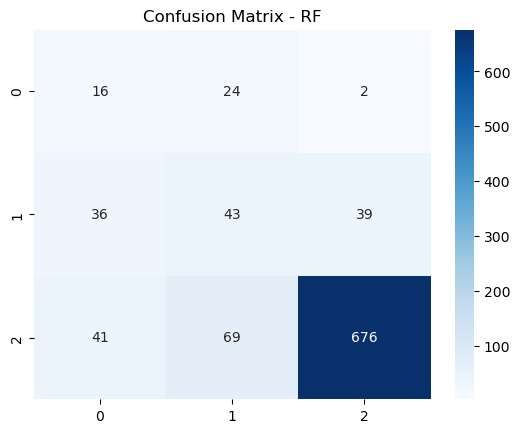


============== FEATURE IMPORTANCE ==============


Feature Importances (Classification) - RF-Engagement_Level
                     Feature  Importance
14        Platform_Frequency    0.180270
23           Platform_TikTok    0.118245
4         Platform_Avg_Likes    0.091490
7        Platform_Avg_Shares    0.066877
10     Platform_Avg_Comments    0.059092
25          Platform_YouTube    0.038536
19           likes_per_month    0.024285
17     days_since_first_post    0.023124
21        comments_per_month    0.022874
12  ContentType_Avg_Comments    0.022025


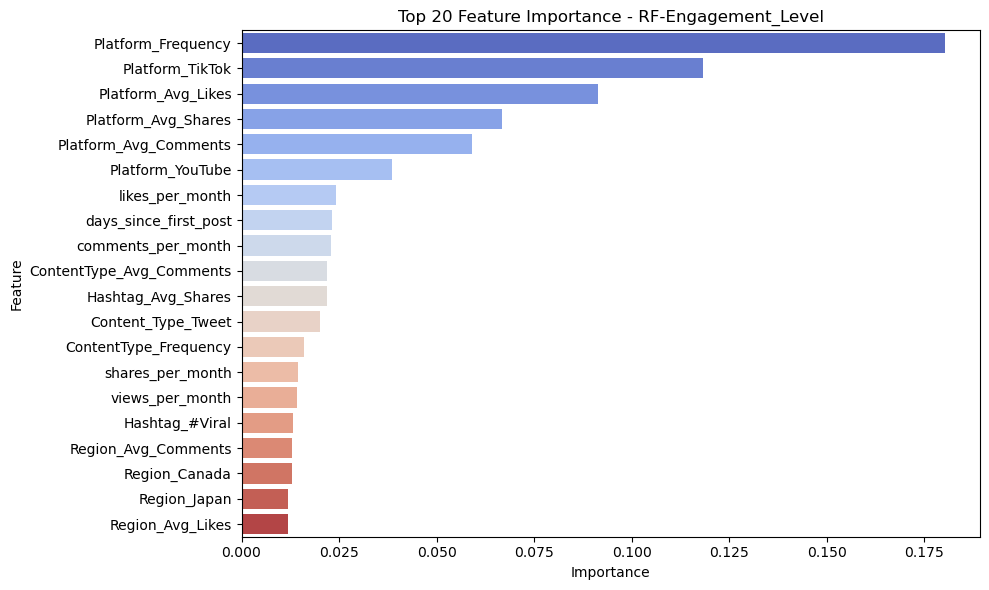


Model: XGB
  Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 20}
  CV F1 Score: 0.8135
  Test Accuracy: 0.7844
  Test Precision: 0.8204
  Test Recall: 0.7844
  Test F1 Score: 0.8006

📗 Classification Hyperparameter Tuning Results Table:
Model                                                                      Best_Params  CV_F1_Score  Test_Accuracy  Test_Precision  Test_Recall  Test_F1_Score
   RF {'model__max_depth': 8, 'model__min_samples_leaf': 1, 'model__n_estimators': 10}     0.816242       0.776956        0.830432     0.776956       0.800150
  XGB  {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 20}     0.813471       0.784355        0.820362     0.784355       0.800631
   Test Accuracy: 0.78 | Test Precision: 0.82 | Test Recall: 0.78 | Test F1: 0.80

================ TEST METRICS ================

              precision    recall  f1-score   support

           0       0.17      0.31      0.22        42
    

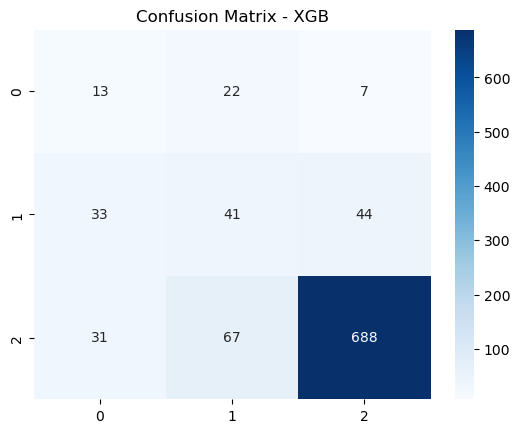


============== FEATURE IMPORTANCE ==============


Feature Importances (Classification) - XGB-Engagement_Level
                  Feature  Importance
23        Platform_TikTok    0.444917
14     Platform_Frequency    0.082870
7     Platform_Avg_Shares    0.080788
43             Region_USA    0.016989
47    Content_Type_Shorts    0.015276
32        Hashtag_#Gaming    0.014709
1      Platform_Avg_Views    0.013516
45      Content_Type_Post    0.013509
10  Platform_Avg_Comments    0.012024
25       Platform_YouTube    0.011889


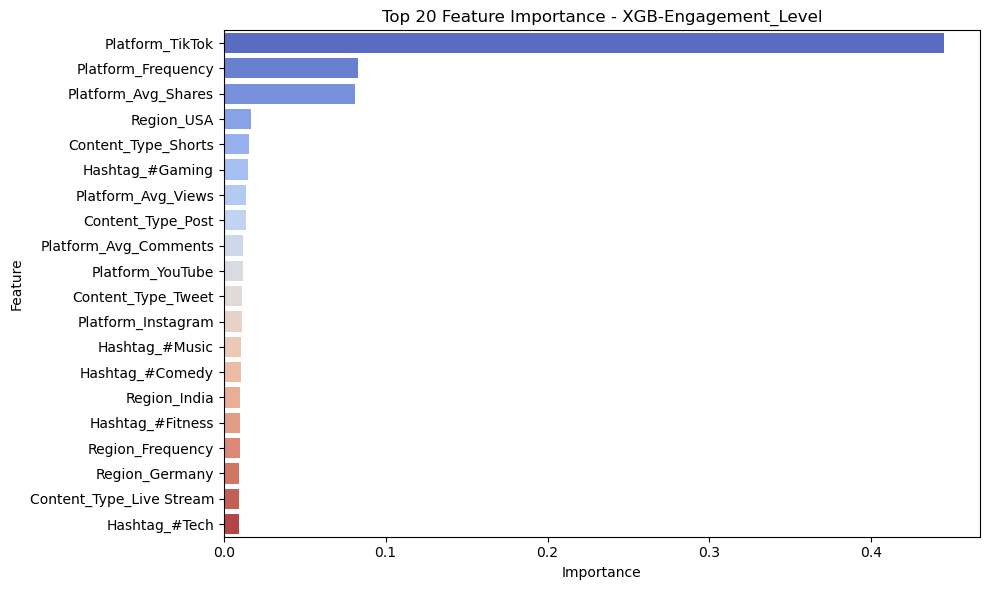


Model: CATBOOST
  Best Params: {'depth': 10, 'iterations': 400, 'learning_rate': 0.06}
  CV F1 Score: 0.8184
  Test Accuracy: 0.7918
  Test Precision: 0.8065
  Test Recall: 0.7918
  Test F1 Score: 0.7984

📗 Classification Hyperparameter Tuning Results Table:
   Model                                                                      Best_Params  CV_F1_Score  Test_Accuracy  Test_Precision  Test_Recall  Test_F1_Score
      RF {'model__max_depth': 8, 'model__min_samples_leaf': 1, 'model__n_estimators': 10}     0.816242       0.776956        0.830432     0.776956       0.800150
     XGB  {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 20}     0.813471       0.784355        0.820362     0.784355       0.800631
CATBOOST                          {'depth': 10, 'iterations': 400, 'learning_rate': 0.06}     0.818445       0.791755        0.806459     0.791755       0.798411
   Test Accuracy: 0.79 | Test Precision: 0.81 | Test Recall: 0.79 | Test F1: 0.80

=========

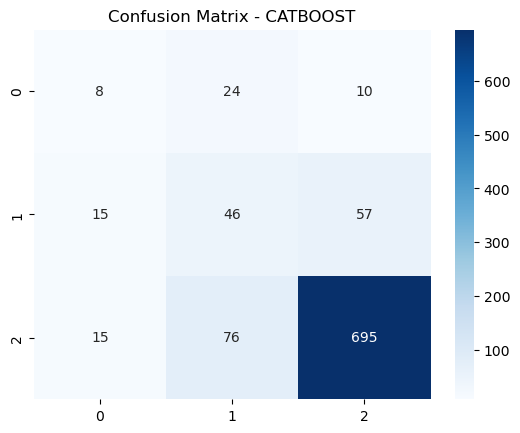


============== FEATURE IMPORTANCE ==============


Feature Importances (Classification) - CATBOOST-Engagement_Level
                     Feature  Importance
21        comments_per_month    6.220979
17     days_since_first_post    6.059231
12  ContentType_Avg_Comments    5.214695
4         Platform_Avg_Likes    5.209696
18           views_per_month    5.192596
20          shares_per_month    5.060430
16     ContentType_Frequency    5.053921
19           likes_per_month    4.724496
7        Platform_Avg_Shares    4.483355
23           Platform_TikTok    4.381054


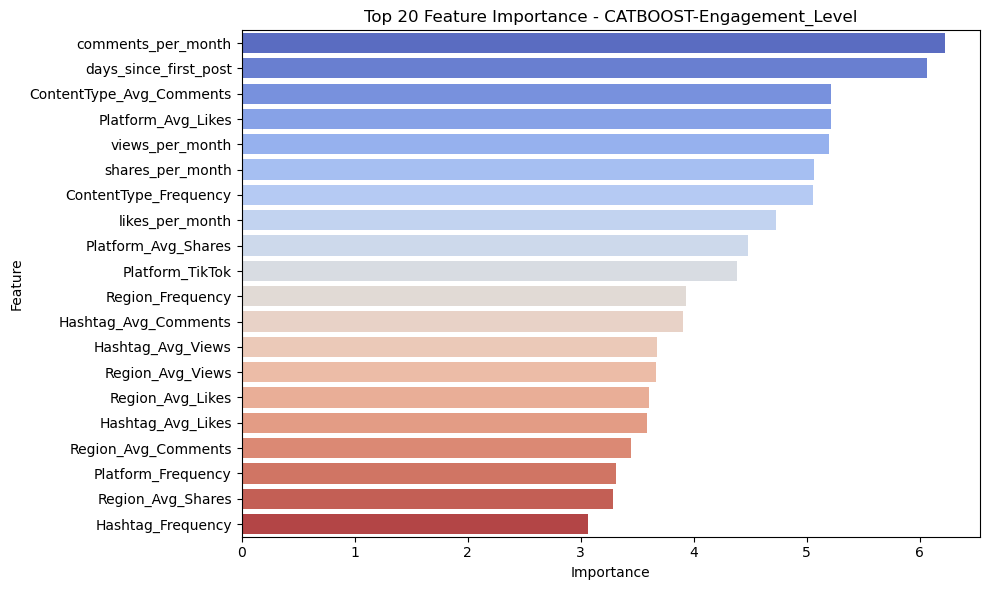

In [45]:


print("===Model Training and Hyperparameter Tuning==")
# # Regression for Views
# hyparam_views = HyparamModels(X_train_reg_views, X_test_reg_views, y_train_reg_views, y_test_reg_views, feature_names_reg_views,task='regression', pred_f='Views',)
# hyparam_views.train_and_evaluate()
# hyparam_views.results()

# # Regression for Likes
# hyparam_likes = HyparamModels(X_train_reg_likes, X_test_reg_likes, y_train_reg_likes, y_test_reg_likes, feature_names_reg_likes, task='regression', pred_f='Likes')
# hyparam_likes.train_and_evaluate()
# hyparam_likes.results()

# # Regression for Shares
# hyparam_shares = HyparamModels(X_train_reg_shares, X_test_reg_shares, y_train_reg_shares, y_test_reg_shares, feature_names_reg_shares, task='regression', pred_f='Shares')
# hyparam_shares.train_and_evaluate()
# hyparam_shares.results()

# # Regression for Comments
# hyparam_comments = HyparamModels(X_train_reg_comments, X_test_reg_comments, y_train_reg_comments, y_test_reg_comments, feature_names_reg_comments, task='regression', pred_f='Comments')
# hyparam_comments.train_and_evaluate()
# hyparam_comments.results()

# Classification
hyparam_cls = HyparamModels(X_train_cls, X_test_cls, y_train_cls, y_test_cls, feature_names_cls, task='classification', pred_f='Engagement_Level')
hyparam_cls.train_and_evaluate()    
hyparam_cls.results()